Epoch     0, Loss: 2.4240e+00, Eq Loss: 5.6173e-01, IC Loss: 1.8623e-03
Epoch  1000, Loss: 2.5563e-01, Eq Loss: 2.5561e-01, IC Loss: 2.1445e-08
Epoch  2000, Loss: 4.5084e-01, Eq Loss: 1.8760e-01, IC Loss: 2.6324e-04
Epoch  3000, Loss: 1.7392e-01, Eq Loss: 1.7392e-01, IC Loss: 3.2013e-09
Epoch  4000, Loss: 1.6965e-01, Eq Loss: 1.6965e-01, IC Loss: 1.2159e-10
Epoch  5000, Loss: 1.6391e-01, Eq Loss: 1.6366e-01, IC Loss: 2.4362e-07
Epoch  6000, Loss: 1.9498e-01, Eq Loss: 1.5711e-01, IC Loss: 3.7862e-05
Epoch  7000, Loss: 1.5854e-01, Eq Loss: 1.5854e-01, IC Loss: 2.1609e-10
Epoch  8000, Loss: 1.4953e-01, Eq Loss: 1.4952e-01, IC Loss: 4.1881e-09
Epoch  9000, Loss: 1.5113e-01, Eq Loss: 1.5113e-01, IC Loss: 4.9888e-11
Epoch 10000, Loss: 1.5034e-01, Eq Loss: 1.4835e-01, IC Loss: 1.9937e-06
Epoch 11000, Loss: 1.4473e-01, Eq Loss: 1.4445e-01, IC Loss: 2.7335e-07
Epoch 12000, Loss: 1.4207e-01, Eq Loss: 1.4189e-01, IC Loss: 1.7292e-07
Epoch 13000, Loss: 1.3357e-01, Eq Loss: 1.3305e-01, IC Loss: 5.2

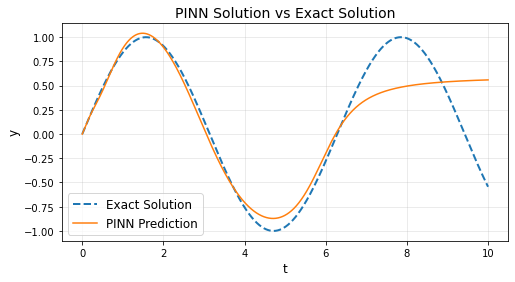

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the PINN network structure
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),    # Input layer: 1 neuron (time t)
            nn.Tanh(),           # Activation function
            nn.Linear(20, 20),   # Hidden layer
            nn.Tanh(),
            nn.Linear(20, 20),   # Hidden layer
            nn.Tanh(),
            nn.Linear(20, 1)     # Output layer: 1 neuron (predicted value y)
        )
    
    def forward(self, t):
        return self.net(t)

# Initialize model and optimizer
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 20000   # Number of training epochs
Nf = 10000           # Number of collocation points
Nic = 1              # Number of initial condition points

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # --- Compute equation loss ---
    # Randomly generate collocation points t ∈ (0, 1]
    t_in = torch.rand(Nf, 1) * 10.0
    t_in.requires_grad = True  # Enable gradient computation
    
    # Forward pass
    y_pred = model(t_in)
    
    # Compute dy/dt using automatic differentiation
    dy_dt = torch.autograd.grad(
        outputs=y_pred,
        inputs=t_in,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True
    )[0]
    
    # Compute the scaled equation residual: dy_dt/1000 + y = sin(t) + cos(t)/1000
    equation = (dy_dt / 1000.0) + y_pred - torch.sin(t_in) - (torch.cos(t_in) / 1000.0)
    loss_equation = torch.mean(equation**2)  # MSE of equation residual
    
    # --- Compute initial condition loss ---
    t_ic = torch.zeros(Nic, 1)  # t = 0
    y_ic = model(t_ic)
    loss_ic = torch.mean((y_ic - 0)**2)  # Initial condition y(0) = 0
    
    # Total loss (assign higher weight to initial condition)
    loss = loss_equation + 1000.0 * loss_ic
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch:5d}, Loss: {loss.item():.4e}, Eq Loss: {loss_equation.item():.4e}, IC Loss: {loss_ic.item():.4e}')

# Testing: generate predictions
t_test = torch.linspace(0, 10, 10000).view(-1, 1)
y_pred = model(t_test).detach().numpy()
y_exact = np.sin(t_test.numpy())  # Exact solution
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Plot results
plt.figure(figsize=(8, 4))
plt.plot(t_test.numpy(), y_exact, label='Exact Solution', linestyle='--', linewidth=2)
plt.plot(t_test.numpy(), y_pred, label='PINN Prediction', linewidth=1.5)
plt.xlabel('t', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend(fontsize=12)
plt.title('PINN Solution vs Exact Solution', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_exact = y_exact.reshape(-1, 1)
y_p_pinn = y_pred
y_true = y_exact
R2_pinn = r2_score(y_p_pinn, y_true)
mae_pinn = mean_absolute_error(y_p_pinn, y_true)
rmse_pinn = mean_squared_error(y_p_pinn, y_true, squared=False)
inf_norm_pinn = np.linalg.norm(y_p_pinn - y_true, ord = np.inf)

print(f"R2_pinn: {R2_pinn}, mae_pinn: {mae_pinn}, rmse_pinn: {rmse_pinn}, inf_norm_pinn: {inf_norm_pinn}")

R2_pinn: 0.7491101604477126, mae_pinn: 0.18213680386543274, rmse_pinn: 0.2880348861217499, inf_norm_pinn: 1.1030069589614868


In [3]:
import numpy as np
import pandas as pd

data_to_save = pd.DataFrame({
    'x': t_test.flatten(),
    'y_pred_pinn': y_p_pinn.flatten(),
    'y_exact': y_true.flatten()
})

# 保存为 CSV 文件
data_to_save.to_csv('pinn_03.csv', index=False)
print(" pinn_03.csv")

数据已保存至 pinn_03.csv
